In [54]:
import numpy as np
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [55]:
action = 'come'

data = np.load(f'dataset/seq_{action}_1681485672.npy') 

(404, 15, 100)

In [57]:
x_data = data[:, :, :-1]
labels = np.zeros(data.shape[0])
print(x_data.shape)
print(labels.shape)

(404, 15)
(404,)


In [58]:
from tensorflow.keras.utils import to_categorical

y_data = to_categorical(labels, num_classes=1)
y_data.shape
from sklearn.model_selection import train_test_split

(404, 1)

In [59]:
x_data = x_data.astype(np.float32)
y_data = y_data.astype(np.float32)

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.1, random_state=2021)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(323, 15) (323, 1)
(81, 15) (81, 1)


In [73]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential([
    LSTM(64, activation='relu', input_shape=x_train.shape[1:3]),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 15, 64)            64        
                                                                 
 lstm_11 (LSTM)              (None, 64)                33024     
                                                                 
 dense_20 (Dense)            (None, 32)                2080      
                                                                 
 dense_21 (Dense)            (None, 1)                 33        
                                                                 
Total params: 35,201
Trainable params: 35,201
Non-trainable params: 0
_________________________________________________________________


In [74]:
model = Sequential([
    LSTM(64, activation='relu', input_shape=x_train.shape[1:3]),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.summary()
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=200,
    callbacks=[
        ModelCheckpoint('models/model.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto'),
        ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=50, verbose=1, mode='auto')
    ]
)

Epoch 1/200
 8/11 [====================>.........] - ETA: 0s - loss: 0.0000e+00 - acc: 1.0000 
Epoch 1: val_loss improved from inf to 0.00000, saving model to models\regression_model.h5
11/11 [==============================] - 2s 33ms/step - loss: 0.0000e+00 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000 - lr: 0.0010
Epoch 2/200
 7/11 [==================>...........] - ETA: 0s - loss: 0.0000e+00 - acc: 1.0000
Epoch 2: val_loss did not improve from 0.00000
11/11 [==============================] - 0s 11ms/step - loss: 0.0000e+00 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000 - lr: 0.0010
Epoch 3/200
 9/11 [=======================>......] - ETA: 0s - loss: 0.0000e+00 - acc: 1.0000
Epoch 3: val_loss did not improve from 0.00000
11/11 [==============================] - 0s 10ms/step - loss: 0.0000e+00 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000 - lr: 0.0010
Epoch 4/200
 9/11 [=======================>......] - ETA: 0s - loss: 0.0000e+00 - acc: 1.0000
Epoch 4: val_lo

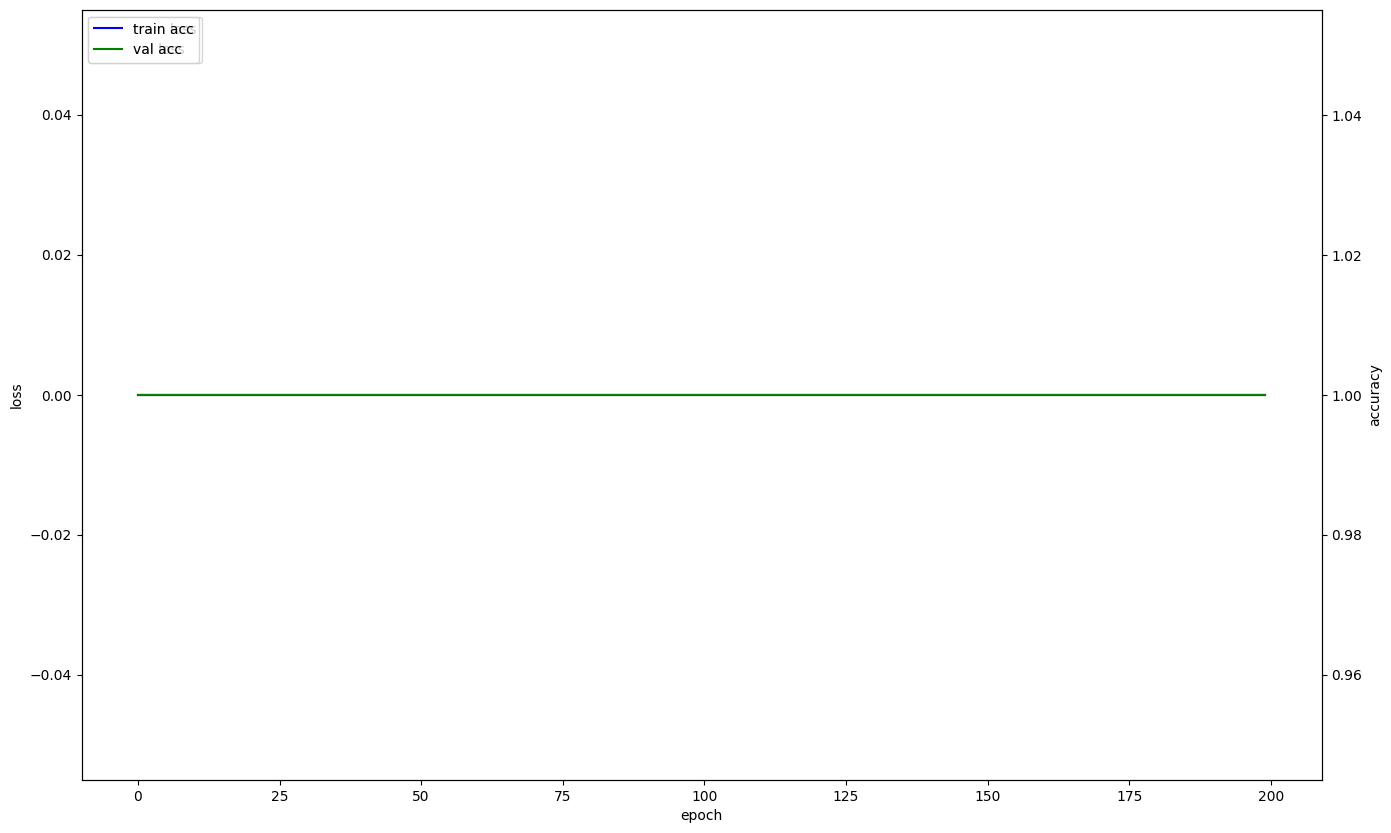

In [75]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

In [84]:
plt.show()
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import load_model

model = load_model('models/model.h5')

y_pred = model.predict(x_val)

confusion_matrix(y_val > 0.5 , y_pred > 0.5)

if len(y_pred) == 1:
    conf = y_pred[0]
else:
    i_pred = int(np.argmax(y_pred))
    conf = y_pred[i_pred]


ValueError: cannot reshape array of size 1215 into shape (15,99)